In [2]:
# =========================================
# Cell 1: Imports and Initial Setup
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Used for train/val split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # Needed for Attention softmax
from torch.utils.data import DataLoader, TensorDataset
import os
import warnings
import copy # For saving best model state

# Optional: SMOTE for class balancing
try:
    from imblearn.over_sampling import SMOTE
    imblearn_available = True
except ImportError:
    print("Warning: imbalanced-learn library not found. SMOTE balancing will be skipped.") # [cite: 338]
    print("Install it using: pip install imbalanced-learn") # [cite: 339]
    imblearn_available = False

# Optional: HMM for market regimes
try:
    from hmmlearn import hmm
    hmmlearn_available = True
except ImportError:
    print("Warning: hmmlearn library not found. Market regime detection will be skipped.")
    hmmlearn_available = False

warnings.filterwarnings('ignore') # [cite: 1, 339]

# Set random seed for reproducibility
np.random.seed(42) # [cite: 339]
torch.manual_seed(42) # [cite: 339]
if torch.cuda.is_available(): # [cite: 339]
    torch.cuda.manual_seed(42) # [cite: 339]

Install it using: pip install imbalanced-learn


In [13]:
# =========================================
# Cell 2: Load Data and Initial View
# =========================================
print("Starting data loading process...") # [cite: 339]
# <<< --- IMPORTANT: SET YOUR FILE PATH HERE --- >>>
file_path = r"C:\Users\User\Downloads\UMHackathon2025\data\merged_on-chain_ohlcv_data.csv" # Modified Placeholder - Original: [cite: 339]
# <<< --- IMPORTANT: SET YOUR FILE PATH HERE --- >>>

try:
    df = pd.read_csv(file_path) # [cite: 339]
    print(f"Original data shape: {df.shape}") # [cite: 339]
    print("\nFirst 5 rows of original data:") # [cite: 339]
    print(df.head()) # [cite: 340]
    print("\nData Info:") # [cite: 340]
    df.info() # [cite: 340]
except FileNotFoundError: # [cite: 340]
    print(f"Error: File not found at {file_path}") # [cite: 340]
    print("Please update the 'file_path' variable in the cell above.") # [cite: 340]
    raise

Starting data loading process...
Original data shape: (246454, 16)

First 5 rows of original data:
      start_time  blockheight      datetime_crypto  flow_mean   flow_total  \
0  1586391082000       625047  2020-04-09 00:11:00  17.346167  2220.309385   
1  1586391445000       625048  2020-04-09 00:17:00  10.060584   352.120455   
2  1586391552000       625049  2020-04-09 00:19:00   4.744710   151.830706   
3  1586391660000       625050  2020-04-09 00:21:00  16.013458   288.242241   
4  1586392040000       625051  2020-04-09 00:27:00   9.521104   457.013011   

   transactions_count_flow  regime         merge_key_datetime     Timestamp  \
0                      128       4  2020-04-09 00:11:00+00:00  1.586391e+09   
1                       35       4  2020-04-09 00:17:00+00:00  1.586391e+09   
2                       32       1  2020-04-09 00:19:00+00:00  1.586392e+09   
3                       18       0  2020-04-09 00:21:00+00:00  1.586392e+09   
4                       48       4  2

In [4]:
# =========================================
# Cell 3: Data Reduction (Optional)
# =========================================
# Keep this cell if you need to limit the dataset size, otherwise, you can remove it.
num_rows_to_keep = -1000000 # [cite: 340]
if len(df) > num_rows_to_keep: # [cite: 340]
    print(f"Reducing dataset to the last {num_rows_to_keep} rows.") # [cite: 340]
    df = df.iloc[-num_rows_to_keep:] # [cite: 340]
    print(f"Reduced data shape: {df.shape}") # [cite: 340]
else:
    print("Dataset size is within the limit, no reduction needed.") # [cite: 340]

Reducing dataset to the last -1000000 rows.
Reduced data shape: (0, 16)


In [14]:
# =========================================
# Cell 4: Timestamp Conversion and Indexing
# =========================================
print("Converting timestamp and setting index...") # [cite: 341]
# Adapt this based on your actual timestamp column name
timestamp_col = 'Timestamp' # Assuming 'Timestamp' - check your CSV
if timestamp_col not in df.columns:
     # Try common alternatives or raise error
     if 'datetime' in df.columns: timestamp_col = 'datetime'
     elif 'Date' in df.columns: timestamp_col = 'Date'
     else: raise KeyError(f"Timestamp column ('{timestamp_col}' or alternatives) not found in DataFrame.")

df[timestamp_col] = pd.to_datetime(df[timestamp_col]) # [cite: 341]
df.set_index(timestamp_col, inplace=True) # [cite: 341]
df.sort_index(inplace=True) # Ensure data is chronologically sorted # [cite: 341]
print("Timestamp converted and set as index.") # [cite: 341]

Converting timestamp and setting index...
Timestamp converted and set as index.


In [15]:
# =========================================
# Cell 5: Data Cleaning (Initial)
# =========================================
print("Cleaning the data...") # [cite: 341]
# Ensure standard OHLCV columns exist if possible
ohlcv_map = {
    'open_price': 'Open', 'high_price': 'High', 'low_price': 'Low',
    'close_price': 'Close', 'volume': 'Volume',
    'market_price_usd': 'Close' # Map market_price_usd if price_close doesn't exist [cite: 73, 79]
}
df.rename(columns=ohlcv_map, inplace=True)

# Convert relevant columns to numeric
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # Basic OHLCV
# Add other known numeric cols from your specific merged file
potential_numeric_cols = ['flow_mean', 'flow_total', 'transactions_count_flow'] # Add others as needed [cite: 341]

for col in df.columns:
    if col in numeric_cols or col in potential_numeric_cols:
         if not pd.api.types.is_numeric_dtype(df[col]):
             try:
                 df[col] = pd.to_numeric(df[col], errors='coerce') # [cite: 341]
             except Exception as e:
                 print(f"Could not convert column {col} to numeric: {e}") # [cite: 341]

# Define flow columns based on *your actual data*
flow_cols = ['flow_mean', 'flow_total', 'transactions_count_flow', 'regime'] # Example [cite: 341]
existing_flow_cols = [col for col in flow_cols if col in df.columns] # [cite: 342]
if existing_flow_cols:
    print(f"Forward filling NaNs in flow columns: {existing_flow_cols}") # [cite: 342]
    df[existing_flow_cols] = df[existing_flow_cols].fillna(method='ffill') # [cite: 342]
    df[existing_flow_cols] = df[existing_flow_cols].fillna(0) # [cite: 342]

# Fill missing OHLCV using ffill first, then 0 if needed (simple approach)
ohlcv_cols_present = [col for col in ['Open', 'High', 'Low', 'Close', 'Volume'] if col in df.columns]
df[ohlcv_cols_present] = df[ohlcv_cols_present].fillna(method='ffill').fillna(0)

print("\nNaN count by column after initial cleaning (showing columns with NaNs):") # [cite: 342]
nan_check = df.isna().sum() # [cite: 342]
print(nan_check[nan_check > 0]) # [cite: 342]


Cleaning the data...
Forward filling NaNs in flow columns: ['flow_mean', 'flow_total', 'transactions_count_flow', 'regime']

NaN count by column after initial cleaning (showing columns with NaNs):
Series([], dtype: int64)


In [16]:
# =========================================
# Cell 6: Feature Engineering Functions
# =========================================
# --- Technical Indicator Functions (from improve.txt Cell 5.5 / CNN-LSTM.txt Cell 7/8) ---
# (Keep your existing functions here for RSI, BB, Stoch, ATR etc.)

def calculate_rsi(series, window=14): # [cite: 342]
    """Calculate Relative Strength Index (RSI)."""
    delta = series.diff() # [cite: 342]
    up = delta.clip(lower=0) # [cite: 343]
    down = -1 * delta.clip(upper=0) # [cite: 343]
    avg_gain = up.rolling(window=window, min_periods=1).mean() # Adjusted for rolling mean
    avg_loss = down.rolling(window=window, min_periods=1).mean() # Adjusted for rolling mean
    rs = avg_gain / avg_loss.replace(0, np.nan) # Avoid division by zero, replace with NaN [cite: 82]
    rsi = 100 - (100 / (1 + rs)) # [cite: 343]
    return rsi.fillna(50) # Fill initial NaNs with 50 (neutral)

def calculate_bollinger_bands(series, window=20, nb_std=2): # [cite: 343]
    """Calculate Bollinger Bands."""
    middle_band = series.rolling(window=window, min_periods=1).mean() # [cite: 344]
    std_dev = series.rolling(window=window, min_periods=1).std() # [cite: 344]
    upper_band = middle_band + (std_dev * nb_std) # [cite: 344]
    lower_band = middle_band - (std_dev * nb_std) # [cite: 344]
    return upper_band, middle_band, lower_band

def calculate_stochastic(high, low, close, k_window=14, d_window=3): # [cite: 344]
    """Calculate Stochastic Oscillator (%K and %D)."""
    lowest_low = low.rolling(window=k_window, min_periods=1).min() # [cite: 345]
    highest_high = high.rolling(window=k_window, min_periods=1).max() # [cite: 345]
    denominator = highest_high - lowest_low # [cite: 345]
    k = 100 * ((close - lowest_low) / denominator.replace(0, np.nan)) # Avoid division by zero [cite: 345]
    d = k.rolling(window=d_window, min_periods=1).mean() # [cite: 345]
    return k.fillna(50), d.fillna(50) # Fill initial NaNs

def calculate_atr(high, low, close, window=14): # [cite: 346]
    """Calculate Average True Range (ATR)."""
    tr1 = high - low # [cite: 346]
    tr2 = abs(high - close.shift()) # [cite: 346]
    tr3 = abs(low - close.shift()) # [cite: 346]
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1) # [cite: 347]
    atr = tr.rolling(window=window, min_periods=1).mean() # [cite: 347]
    return atr

def calculate_macd(series, span1=12, span2=26, signal_span=9): # [cite: 83]
    """Calculate MACD, MACD Signal, and MACD Histogram."""
    ema1 = series.ewm(span=span1, adjust=False).mean() # [cite: 83, 356]
    ema2 = series.ewm(span=span2, adjust=False).mean() # [cite: 83, 356]
    macd = ema1 - ema2 # [cite: 83, 356]
    macd_signal = macd.ewm(span=signal_span, adjust=False).mean() # [cite: 83, 356]
    macd_hist = macd - macd_signal # [cite: 83]
    return macd, macd_signal, macd_hist

print("Feature engineering functions defined.")

Feature engineering functions defined.


In [17]:
# =========================================
# Cell 7: Apply Basic Technical Features
# =========================================
print("Applying basic technical features...")

# Ensure we have a closing price column
price_col = 'Close'
if price_col not in df.columns:
    raise ValueError(f"Required column '{price_col}' not found after cleaning.")

df['Returns'] = df[price_col].pct_change() # [cite: 356]
df['Log_Returns'] = np.log(df[price_col] / df[price_col].shift(1)) # Similar to [cite: 80]

# Moving Averages
windows = [5, 10, 20, 50, 200] # [cite: 81, 348, 356]
for w in windows:
    df[f'MA{w}'] = df[price_col].rolling(window=w, min_periods=1).mean() # [cite: 81, 348, 356]

# MACD
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = calculate_macd(df[price_col]) # [cite: 83, 356]

# RSI
df['RSI'] = calculate_rsi(df[price_col], window=14) # [cite: 82, 357]

# Bollinger Bands
df['BB_Upper'], df['BB_Middle'], df['BB_Lower'] = calculate_bollinger_bands(df[price_col], window=20) # [cite: 357]
df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle'].replace(0, np.nan) # Avoid division by zero [cite: 357]

# Stochastic Oscillator
if all(c in df.columns for c in ['High', 'Low']):
    df['Stoch_K'], df['Stoch_D'] = calculate_stochastic(df['High'], df['Low'], df[price_col], k_window=14, d_window=3) # [cite: 357]
else: print("Warning: High/Low columns missing, skipping Stochastic Oscillator.")

# ATR
if all(c in df.columns for c in ['High', 'Low']):
    df['ATR'] = calculate_atr(df['High'], df['Low'], df[price_col], window=14) # [cite: 357]
else: print("Warning: High/Low columns missing, skipping ATR.")

print("Basic technical features applied.")

Applying basic technical features...
Basic technical features applied.


In [18]:
# =========================================
# Cell 8: Apply Volatility and Trend Features
# =========================================
print("Applying volatility and trend features...")

# Volatility (using returns)
vol_windows = [7, 14, 30, 60] # [cite: 80]
for w in vol_windows:
    df[f'Volatility_{w}d'] = df['Returns'].rolling(window=w, min_periods=1).std() * np.sqrt(w) # Scaled volatility

# Moving Average Crossovers [cite: 81]
if 'MA5' in df.columns and 'MA20' in df.columns: df['MA_Cross_5_20'] = df['MA5'] - df['MA20']
if 'MA10' in df.columns and 'MA50' in df.columns: df['MA_Cross_10_50'] = df['MA10'] - df['MA50'] # Example
if 'MA50' in df.columns and 'MA200' in df.columns: df['MA_Cross_50_200'] = df['MA50'] - df['MA200'] # [cite: 82]

# Trend Direction based on long/short MAs [cite: 348]
if 'MA50' in df.columns and 'MA200' in df.columns:
     df['Trend_Direction'] = np.where(df['MA50'] > df['MA200'], 1,
                                     np.where(df['MA50'] < df['MA200'], -1, 0)) # [cite: 348]
     # Trend Change Detection
     df['Trend_Change'] = df['Trend_Direction'].diff().fillna(0) # [cite: 349] adapted
else: print("Warning: MA50 or MA200 missing, skipping Trend Direction/Change.")

print("Volatility and trend features applied.")

Applying volatility and trend features...
Volatility and trend features applied.


In [19]:
# =========================================
# Cell 9: Apply Price/Volume Interaction Features
# =========================================
print("Applying price/volume features...")

if 'Volume' in df.columns:
    # Volume Change/Momentum
    df['Volume_Change'] = df['Volume'].pct_change() # [cite: 358]
    df['Volume_Momentum_5d'] = df['Volume'].pct_change(periods=5) # [cite: 353]

    # Volume Moving Averages
    vol_ma_windows = [5, 20, 50] # [cite: 353]
    for w in vol_ma_windows:
        df[f'Volume_MA{w}'] = df['Volume'].rolling(window=w, min_periods=1).mean() # [cite: 353]

    # Volume relative to MA
    if 'Volume_MA20' in df.columns:
        df['Volume_Ratio'] = df['Volume'] / df['Volume_MA20'].replace(0, np.nan) # [cite: 353, 358]

    # Price-Volume Product (simple interaction)
    df['Price_Volume'] = df[price_col] * df['Volume'] # [cite: 358]

    # On-Balance Volume (OBV)
    obv = pd.Series(0, index=df.index) # [cite: 354]
    price_diff = df[price_col].diff()
    obv = np.where(price_diff > 0, df['Volume'], np.where(price_diff < 0, -df['Volume'], 0)).cumsum()
    df['OBV'] = pd.Series(obv, index=df.index) # [cite: 354]

else:
    print("Warning: 'Volume' column not found. Skipping volume-related features.")

print("Price/volume features applied.")


Applying price/volume features...
Price/volume features applied.


In [20]:
# =========================================
# Cell 10: Define Target Variable
# =========================================
print("Defining target variable...")
# Predicting direction 1 day ahead
df['Target_Return_1d'] = df['Returns'].shift(-1) # [cite: 358] adapted
df['Target_Direction_1d'] = np.where(df['Target_Return_1d'] > 0, 1, 0) # [cite: 358]

# Optional: Predicting direction N days ahead (e.g., 7 days)
days_ahead = 7
if len(df) > days_ahead:
    df[f'Target_Return_{days_ahead}d'] = df[price_col].shift(-days_ahead) / df[price_col] - 1 # [cite: 96]
    df[f'Target_Direction_{days_ahead}d'] = np.where(df[f'Target_Return_{days_ahead}d'] > 0, 1, 0) # [cite: 96] adapted

print("Target variable(s) defined.")
print(f"\nColumns after feature engineering: {len(df.columns)}")
print(df.head())

Defining target variable...
Target variable(s) defined.

Columns after feature engineering: 54
                                  start_time  blockheight  \
Timestamp                                                   
1970-01-01 00:00:01.586391060  1586391082000       625047   
1970-01-01 00:00:01.586391420  1586391445000       625048   
1970-01-01 00:00:01.586391540  1586391552000       625049   
1970-01-01 00:00:01.586391660  1586391660000       625050   
1970-01-01 00:00:01.586392020  1586392040000       625051   

                                   datetime_crypto  flow_mean   flow_total  \
Timestamp                                                                    
1970-01-01 00:00:01.586391060  2020-04-09 00:11:00  17.346167  2220.309385   
1970-01-01 00:00:01.586391420  2020-04-09 00:17:00  10.060584   352.120455   
1970-01-01 00:00:01.586391540  2020-04-09 00:19:00   4.744710   151.830706   
1970-01-01 00:00:01.586391660  2020-04-09 00:21:00  16.013458   288.242241   
1970-01-0

In [21]:
# =========================================
# Cell 11: Feature Engineering - Add On-chain/Flow/Other Features (Optional)
# =========================================
print("Applying additional features (if columns exist)...")

# --- Add features inspired by CNN-LSTM.txt Cell 8 ---
# --- Adapt these based on the *actual* columns available in your merged df ---

# Example: NVT Ratio (adjust column names if needed)
if 'market_cap_usd' in df.columns and 'transactions_count_flow' in df.columns: # Using transactions_count_flow as proxy for transaction rate/volume
    # Need a measure of daily transaction value if possible, using count as rough proxy
    df['nvt_proxy'] = df['market_cap_usd'] / df['transactions_count_flow'].replace(0, np.nan) #
elif 'market_cap_usd' in df.columns and 'Volume' in df.columns: # Alternative proxy using trading volume
     df['nvt_proxy'] = df['market_cap_usd'] / (df[price_col] * df['Volume']).rolling(window=7).mean().replace(0, np.nan) # Using 7d avg value traded
else: print("Warning: Columns for NVT calculation not found.")

# Example: MVRV Ratio (adjust column names if needed)
if 'market_cap_usd' in df.columns and 'realised_cap_usd' in df.columns: #
    df['mvrv_ratio'] = df['market_cap_usd'] / df['realised_cap_usd'].replace(0, np.nan) #
else: print("Warning: Columns for MVRV calculation not found.")

# Example: Flow Z-Score (adjust column names if needed)
if 'flow_total' in df.columns: #
    for window in [7, 14, 30]: #
        flow_mean = df['flow_total'].rolling(window).mean() #
        flow_std = df['flow_total'].rolling(window).std() #
        df[f'flow_zscore_{window}d'] = (df['flow_total'] - flow_mean) / flow_std.replace(0, np.nan) #
else: print("Warning: 'flow_total' column not found for Z-score.")

# Example: Whale Dominance (adjust column names if needed)
balance_cols_map = { # Map potential names in your CSV to standard ones used in CNN-LSTM.txt
    'addressesBalanceGreaterThan1k': 'addresses_with_1000_btc',
    'addressesBalanceGreaterThan100': 'addresses_with_100_btc',
    # ... add mappings for other balance columns if they exist in your data
}
df.rename(columns=balance_cols_map, inplace=True)
required_balance_cols = ['addresses_with_1000_btc', 'addresses_with_100_btc'] # Minimum for basic whale metric
if all(col in df.columns for col in required_balance_cols): #
    whale_balance = df['addresses_with_1000_btc'] + df['addresses_with_100_btc'] #
    # Attempt to find total address count or use a proxy
    total_active_addresses = df['transactions_count_flow'] if 'transactions_count_flow' in df.columns else None # Very rough proxy
    if total_active_addresses is not None:
        df['whale_dominance_proxy'] = whale_balance / total_active_addresses.replace(0, np.nan) #
    else:
        # Use change in whale addresses as proxy if total count unavailable
        df['whale_addr_change_7d'] = whale_balance.diff(periods=7) #
else: print("Warning: Columns for Whale Dominance calculation not found.")

print("Additional features applied.")

Applying additional features (if columns exist)...
Additional features applied.


In [12]:
# =========================================
# Cell 12: Final NaN Handling
# =========================================
print("Handling final NaN values after all feature engineering...") #

initial_nan_count = df.isna().sum().sum() #
print(f"NaN count before final filling: {initial_nan_count}") #

# Replace infinite values that might arise from calculations
df.replace([np.inf, -np.inf], np.nan, inplace=True) #

# Use ffill first (most common for time series)
df.fillna(method='ffill', inplace=True) #
# Use bfill to fill any NaNs at the very beginning
df.fillna(method='bfill', inplace=True) #
# As a final safeguard, fill any remaining NaNs with 0 (e.g., if whole columns were NaN)
df.fillna(0, inplace=True) #

# Drop rows where the primary target is missing (e.g., the last few rows due to shift)
target_column_name = 'Target_Direction_1d' # Choose your primary target
initial_rows = len(df) #
# Need to store the original target before filling potentially
original_target = df[target_column_name].copy()
# Re-calculate the target based on original price *before* filling, to avoid lookahead bias on fill
# This step depends on how target was calculated. Assuming 'Returns' is reliable:
# df['Target_Return_1d'] = df['Returns'].shift(-1) # Re-calculate before dropna
# df[target_column_name] = np.where(df['Target_Return_1d'] > 0, 1, 0) # Re-calculate before dropna

# Drop rows where target calculation resulted in NaN (typically last row(s))
# It's often safer to drop based on the *source* of the target calculation before shift
# E.g., drop the last row since 'Returns' shifted by -1 will be NaN there.
if 'Target_Return_1d' in df.columns:
     df.dropna(subset=['Target_Return_1d'], inplace=True) # Drop based on the shifted return being NaN
else:
     # Fallback: If target return wasn't kept, drop last row(s) == shift amount
     shift_amount = 1 # For Target_Direction_1d
     if len(df) > shift_amount:
         df = df.iloc[:-shift_amount]


final_rows = len(df) #
print(f"Dropped {initial_rows - final_rows} rows (primarily last rows with NaN target).") #

print(f"\nData shape after all preprocessing: {df.shape}") #
final_nan_count = df.isna().sum().sum() #
if final_nan_count > 0: #
     print(f"\nError: {final_nan_count} NaNs still remain after final filling!") #
     print(df.isna().sum()[df.isna().sum() > 0]) #
else:
     print("\nConfirmed: No NaNs remain in the DataFrame.") #


Handling final NaN values after all feature engineering...
NaN count before final filling: 1245994
Dropped 0 rows (primarily last rows with NaN target).

Data shape after all preprocessing: (1433121, 54)

Confirmed: No NaNs remain in the DataFrame.


In [13]:
# =========================================
# Cell 13: Feature Selection
# =========================================
# Define core features you definitely want
core_features = ['Open', 'High', 'Low', 'Close', 'Volume'] #

# Define feature categories based on calculations above
ma_features = [f'MA{w}' for w in windows]
volatility_features = [f'Volatility_{w}d' for w in vol_windows]
indicator_features = ['Returns', 'Log_Returns', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'BB_Width', 'Stoch_K', 'Stoch_D', 'ATR']
trend_features = ['MA_Cross_5_20', 'MA_Cross_10_50', 'MA_Cross_50_200', 'Trend_Direction', 'Trend_Change']
volume_features = ['Volume_Change', 'Volume_Momentum_5d', 'Volume_MA5', 'Volume_MA20', 'Volume_MA50', 'Volume_Ratio', 'Price_Volume', 'OBV']
flow_features = [f'flow_zscore_{w}d' for w in [7, 14, 30]] + ['nvt_proxy', 'mvrv_ratio'] # Add other flow/onchain features calculated
# Add other categories as needed (e.g., HODL waves if calculated)

# Combine all potential features
potential_features = core_features + ma_features + volatility_features + indicator_features + trend_features + volume_features + flow_features

# Select only features that actually exist in the dataframe *after* cleaning
feature_columns = [col for col in potential_features if col in df.columns] #

# Final check for NaNs within selected features
print("\nFinal check on selected feature columns...") #
valid_feature_columns = [] #
for col in feature_columns: #
    if df[col].isna().any(): #
        print(f"Error: Column '{col}' selected contains NaN values AFTER final cleaning. Removing.") #
    else:
        valid_feature_columns.append(col) #

feature_columns = valid_feature_columns # Use only valid columns #

# Define the target column to be used for prediction
target_column_name = 'Target_Direction_1d' # Or 'Target_Direction_7d' etc.
if target_column_name not in df.columns:
    raise ValueError(f"Target column '{target_column_name}' not found in DataFrame.")

print(f"\nFinal features being used ({len(feature_columns)}): {feature_columns}") #
if not feature_columns: #
    raise ValueError("No valid feature columns remaining after checks!") #


Final check on selected feature columns...

Final features being used (40): ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200', 'Volatility_7d', 'Volatility_14d', 'Volatility_30d', 'Volatility_60d', 'Returns', 'Log_Returns', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'BB_Width', 'Stoch_K', 'Stoch_D', 'ATR', 'MA_Cross_5_20', 'MA_Cross_10_50', 'MA_Cross_50_200', 'Trend_Direction', 'Trend_Change', 'Volume_Change', 'Volume_Momentum_5d', 'Volume_MA5', 'Volume_MA20', 'Volume_MA50', 'Volume_Ratio', 'Price_Volume', 'OBV', 'flow_zscore_7d', 'flow_zscore_14d', 'flow_zscore_30d']


In [14]:
# =========================================
# Cell 14: Prepare X, y and Scale Features
# =========================================
X = df[feature_columns].values #
y = df[target_column_name].values # Using the defined target column

print("X (features) shape:", X.shape) #
print("y (target) shape:", y.shape) #

# Check class distribution
print("\nTarget variable distribution:")
print(pd.Series(y).value_counts(normalize=True))

scaler = StandardScaler() #
X_scaled = scaler.fit_transform(X) #
print("X_scaled shape:", X_scaled.shape) #
print("Scaling complete.") #

X (features) shape: (1433121, 40)
y (target) shape: (1433121,)

Target variable distribution:
0    0.544232
1    0.455768
Name: proportion, dtype: float64
X_scaled shape: (1433121, 40)
Scaling complete.


In [15]:
# =========================================
# Cell 15: Train/Validation/Test Split (Chronological)
# =========================================
# Define split percentages
train_percent = 0.7
val_percent = 0.15
test_percent = 0.15 # Ensure train + val + test = 1.0

if not (train_percent + val_percent + test_percent == 1.0):
    raise ValueError("Split percentages must sum to 1.0")

n = len(X_scaled)
train_end_idx = int(n * train_percent)
val_end_idx = train_end_idx + int(n * val_percent)

X_train, y_train = X_scaled[:train_end_idx], y[:train_end_idx]
X_val, y_val = X_scaled[train_end_idx:val_end_idx], y[train_end_idx:val_end_idx]
X_test, y_test = X_scaled[val_end_idx:], y[val_end_idx:]

# Store sizes for potential use later (e.g., aligning predictions)
final_train_size = len(X_train) #
val_size = len(X_val) #
test_size = len(X_test) #

print(f"\nTotal data points: {n}") #
print(f"Final Training set size: {final_train_size} samples ({len(X_train)/n:.1%})") #
print(f"Validation set size: {val_size} samples ({len(X_val)/n:.1%})") #
print(f"Testing set size: {test_size} samples ({len(X_test)/n:.1%})") #
assert final_train_size + val_size + test_size == n, "Split sizes error!" #



Total data points: 1433121
Final Training set size: 1003184 samples (70.0%)
Validation set size: 214968 samples (15.0%)
Testing set size: 214969 samples (15.0%)


In [16]:
# =========================================
# Cell 16: Sequence Creation Function
# =========================================
def create_sequences(X, y, time_steps=10): #
    """Creates sequences for time series forecasting."""
    Xs, ys = [], [] #
    for i in range(len(X) - time_steps): #
        Xs.append(X[i:(i + time_steps)]) #
        ys.append(y[i + time_steps]) #
    # Handle case where input length is less than time_steps
    if not Xs: #
        # Return empty arrays with correct dimensions if possible
        n_features = X.shape[1] if X.ndim == 2 else 0 #
        return np.empty((0, time_steps, n_features)), np.empty((0,)) #
    return np.array(Xs), np.array(ys) #

In [17]:
# =========================================
# Cell 17: Apply Sequence Creation
# =========================================
time_steps = 20 # Define the lookback period (e.g., 20 days)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps) #
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps) #
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps) #

print(f"\nTraining sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}") #
print(f"Validation sequences shape: {X_val_seq.shape}, Target shape: {y_val_seq.shape}") #
print(f"Testing sequences shape: {X_test_seq.shape}, Target shape: {y_test_seq.shape}") #

if X_train_seq.shape[0] == 0: raise ValueError("Training sequence set is empty. Check data length and time_steps.") #
if X_val_seq.shape[0] == 0: print("\nWarning: Validation sequence set is empty.") #
if X_test_seq.shape[0] == 0: print("\nWarning: Test sequence set is empty.") #

input_size = X_train_seq.shape[2] # Should be number of features
print(f"\nInput size (number of features) for model: {input_size}") #


Training sequences shape: (1003164, 20, 40), Target shape: (1003164,)
Validation sequences shape: (214948, 20, 40), Target shape: (214948,)
Testing sequences shape: (214949, 20, 40), Target shape: (214949,)

Input size (number of features) for model: 40


In [18]:
# =========================================
# Cell 18: Apply SMOTE for Class Balancing (Optional)
# =========================================
apply_smote = False # <-- Set to True to try SMOTE balancing

if apply_smote and imblearn_available and X_train_seq.shape[0] > 0: #
    print("\nAttempting SMOTE on training data...") #
    n_samples, n_timesteps, n_features = X_train_seq.shape #
    # Reshape sequences for SMOTE (samples, features*timesteps)
    X_train_flat = X_train_seq.reshape(n_samples, n_timesteps * n_features) #
    y_train_flat = y_train_seq #

    print(f"Original training data shape (flattened): {X_train_flat.shape}") #
    print(f"Original class distribution: {np.bincount(y_train_flat.astype(int))}") #

    # Ensure k_neighbors is less than the number of samples in the smallest class
    min_class_count = np.min(np.bincount(y_train_flat.astype(int)))
    k_neighbors = min(5, max(1, min_class_count - 1)) # Ensure k>=1 and k< minority samples

    if k_neighbors < 1:
        print("Warning: Not enough samples in the minority class for SMOTE. Skipping.")
        X_train_seq_final = X_train_seq
        y_train_seq_final = y_train_seq
        use_balanced_data = False
    else:
        print(f"Using k_neighbors={k_neighbors} for SMOTE.")
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors) #
        try:
            X_train_balanced_flat, y_train_balanced = smote.fit_resample(X_train_flat, y_train_flat) #

            print(f"Balanced training data shape (flattened): {X_train_balanced_flat.shape}") #
            print(f"Balanced class distribution: {np.bincount(y_train_balanced.astype(int))}") #

            # Reshape back to sequences (samples, timesteps, features)
            X_train_balanced_seq = X_train_balanced_flat.reshape(-1, n_timesteps, n_features) #

            # Update sequence variables for DataLoader creation
            X_train_seq_final = X_train_balanced_seq #
            y_train_seq_final = y_train_balanced #
            print("SMOTE applied successfully.") #
            use_balanced_data = True #
        except ValueError as e: #
            print(f"SMOTE failed: {e}. Using original data.") #
            X_train_seq_final = X_train_seq #
            y_train_seq_final = y_train_seq #
            use_balanced_data = False #
else:
    if not imblearn_available and apply_smote: print("\nSkipping SMOTE: imblearn not installed.") #
    elif not apply_smote: print("\nSkipping SMOTE: 'apply_smote' is False.") #
    elif X_train_seq.shape[0] == 0: print("\nSkipping SMOTE: No training data.") #
    else: print("\nUsing original (unbalanced) training data.")
    X_train_seq_final = X_train_seq #
    y_train_seq_final = y_train_seq #
    use_balanced_data = False #


Skipping SMOTE: 'apply_smote' is False.


In [19]:
# =========================================
# Cell 19: Convert to PyTorch Tensors
# =========================================
# Use the final (potentially balanced) training sequences
X_train_tensor = torch.FloatTensor(X_train_seq_final) #
y_train_tensor = torch.FloatTensor(y_train_seq_final).unsqueeze(1) # Add dimension for BCELoss

# Use original validation and test sequences
X_val_tensor = torch.FloatTensor(X_val_seq) #
y_val_tensor = torch.FloatTensor(y_val_seq).unsqueeze(1) # Add dimension

X_test_tensor = torch.FloatTensor(X_test_seq) #
y_test_tensor = torch.FloatTensor(y_test_seq).unsqueeze(1) # Add dimension

print("\nTensor shapes:") #
print(f"X_train_tensor: {X_train_tensor.shape}") #
print(f"y_train_tensor: {y_train_tensor.shape}") #
print(f"X_val_tensor: {X_val_tensor.shape}") #
print(f"y_val_tensor: {y_val_tensor.shape}") #
print(f"X_test_tensor: {X_test_tensor.shape}") #
print(f"y_test_tensor: {y_test_tensor.shape}") #


Tensor shapes:
X_train_tensor: torch.Size([1003164, 20, 40])
y_train_tensor: torch.Size([1003164, 1])
X_val_tensor: torch.Size([214948, 20, 40])
y_val_tensor: torch.Size([214948, 1])
X_test_tensor: torch.Size([214949, 20, 40])
y_test_tensor: torch.Size([214949, 1])


In [20]:
# =========================================
# Cell 20: Create DataLoaders
# =========================================
batch_size = 128 # Adjusted batch size

# Training DataLoader (uses balanced data if SMOTE was applied and successful)
if X_train_tensor.shape[0] > 0:
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor) #
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle training data
else:
    train_loader = None
    print("Warning: Training data is empty, train_loader not created.")

# Validation DataLoader
if X_val_tensor.shape[0] > 0: #
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor) #
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # No shuffle for validation
else:
    val_loader = None #
    print("Validation data is empty, val_loader not created.") #

# Testing DataLoader
if X_test_tensor.shape[0] > 0:
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor) #
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # No shuffle for testing
else:
    test_loader = None
    print("Warning: Test data is empty, test_loader not created.") #

print(f"\nDataLoaders created with batch size: {batch_size}") #
print(f"Using {'balanced' if use_balanced_data else 'original'} training data.") #


DataLoaders created with batch size: 128
Using original training data.


In [21]:
# =========================================
# Cell 21: CNN-LSTM Model Definition
# =========================================
# Based on improve.txt Cell 15 (Modified)
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,
                 dropout_prob=0.3, num_cnn_layers=2, cnn_filters=None, cnn_kernel_size=3):
        super(CNNLSTMModel, self).__init__()
        self.hidden_size = hidden_size #
        self.num_layers = num_layers #

        # --- CNN Layers ---
        if cnn_filters is None: #
            cnn_filters = [32, 64] # Default filters
        if len(cnn_filters) != num_cnn_layers: #
            raise ValueError(f"Expected {num_cnn_layers} CNN filter values, got {len(cnn_filters)}") #

        self.cnn_layers = nn.ModuleList() #
        in_channels = input_size  # Input features are treated as channels for Conv1d #
        cnn_output_channels = in_channels # Initialize in case num_cnn_layers is 0

        for i in range(num_cnn_layers): #
            out_channels = cnn_filters[i] #
            # Calculate padding to maintain sequence length: padding = (kernel_size - 1) // 2
            padding = (cnn_kernel_size - 1) // 2
            self.cnn_layers.append(nn.Sequential( #
                nn.Conv1d(in_channels, out_channels, kernel_size=cnn_kernel_size, padding=padding), #
                nn.ReLU(), #
                nn.BatchNorm1d(out_channels), # Add BatchNorm
                # Optional: Add Dropout within CNN
                # nn.Dropout(dropout_prob * 0.5) # Smaller dropout for CNN layers
            )) #
            in_channels = out_channels # Output channels of this layer is input for the next #
            cnn_output_channels = out_channels # Store the last output channels

        # --- LSTM Layer ---
        # Input size for LSTM is the number of output channels from the last CNN layer
        lstm_input_size = cnn_output_channels #
        self.lstm = nn.LSTM(lstm_input_size, hidden_size, num_layers, #
                            batch_first=True, dropout=dropout_prob if num_layers > 1 else 0, #
                            bidirectional=True) # Using Bidirectional LSTM #

        # --- Attention Layer ---
        # Input to attention is the output of LSTM (hidden_size * 2 because bidirectional)
        self.attention = nn.Linear(hidden_size * 2, 1) #

        # --- Fully Connected Layers ---
        # Input to FC layers is the context vector from attention (hidden_size * 2)
        fc_input_size = hidden_size * 2
        self.bn_fc = nn.BatchNorm1d(fc_input_size) # BatchNorm before FC layers #
        self.fc1 = nn.Linear(fc_input_size, hidden_size) #
        self.relu1 = nn.ReLU() #
        self.dropout1 = nn.Dropout(dropout_prob) #
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2) #
        self.relu2 = nn.ReLU() #
        self.dropout2 = nn.Dropout(dropout_prob) #
        self.fc3 = nn.Linear(hidden_size // 2, output_size) #
        self.sigmoid = nn.Sigmoid() # Use Sigmoid for BCELoss #

    def forward(self, x):
        # Input x shape: [batch_size, seq_len, input_size]

        # --- CNN Forward ---
        # Conv1d expects input as [batch_size, channels=input_size, seq_len]
        x_cnn = x.transpose(1, 2) # Transpose to fit Conv1d #
        for cnn_layer in self.cnn_layers: #
            x_cnn = cnn_layer(x_cnn) #
        # Output x_cnn shape: [batch_size, cnn_output_channels, seq_len]

        # --- LSTM Forward ---
        # LSTM expects input as [batch_size, seq_len, features=cnn_output_channels]
        x_lstm = x_cnn.transpose(1, 2) # Transpose back #

        # Initialize hidden and cell states (for bidirectional)
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) # *2 for bidirectional #
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) # *2 for bidirectional #
        lstm_out, _ = self.lstm(x_lstm, (h0, c0)) #
        # lstm_out shape: [batch_size, seq_len, hidden_size * 2]

        # --- Attention Forward ---
        # Calculate attention weights
        attn_weights = F.softmax(self.attention(lstm_out), dim=1) # Apply softmax over sequence length dim #
        # Calculate context vector by weighted sum
        context_vector = torch.sum(attn_weights * lstm_out, dim=1) # Shape: [batch_size, hidden_size * 2] #

        # --- Fully Connected Forward ---
        context_vector = self.bn_fc(context_vector) # Apply BatchNorm #
        out = self.fc1(context_vector) #
        out = self.relu1(out) #
        out = self.dropout1(out) #
        out = self.fc2(out) #
        out = self.relu2(out) #
        out = self.dropout2(out) #
        out = self.fc3(out) #
        out = self.sigmoid(out) # Apply sigmoid for probability output #

        return out #

print("CNNLSTMModel class defined.")

CNNLSTMModel class defined.


In [22]:
# =========================================
# Cell 22: Initialize CNN-LSTM Model, Loss, Optimizer, Scheduler
# =========================================
# Model Hyperparameters
hidden_size = 64         # LSTM hidden units
num_lstm_layers = 2      # Number of LSTM layers
output_size = 1          # Binary classification (0 or 1)
dropout_prob = 0.3       # Dropout probability

# CNN Hyperparameters
num_cnn_layers = 2       # Number of Conv1D layers
cnn_filters = [32, 64]   # Filters for each Conv1D layer (e.g., 2 layers: [32, 64])
cnn_kernel_size = 3      # Kernel size for Conv1D

# Training Hyperparameters
learning_rate = 0.001
scheduler_patience = 5
scheduler_factor = 0.1

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #
print(f"Using device: {device}") #

# Ensure input_size is defined from Cell 17
if 'input_size' not in locals():
     raise NameError("Variable 'input_size' not defined. Ensure Cell 17 ran successfully.")

# Initialize the CNN-LSTM model
cnn_lstm_model = CNNLSTMModel(
    input_size=input_size, # From Cell 17
    hidden_size=hidden_size,
    num_layers=num_lstm_layers,
    output_size=output_size,
    dropout_prob=dropout_prob,
    num_cnn_layers=num_cnn_layers,
    cnn_filters=cnn_filters,
    cnn_kernel_size=cnn_kernel_size
).to(device) #

print("\nCNN-LSTM Model Architecture:") #
print(cnn_lstm_model) #

# Loss Function (Binary Cross Entropy for binary classification)
criterion = nn.BCELoss() #

# Optimizer (Adam is a common choice)
optimizer = optim.Adam(cnn_lstm_model.parameters(), lr=learning_rate) #

# Learning Rate Scheduler (Reduce LR on plateau)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True #
)

print(f"\nLoss: {criterion}") #
print(f"Optimizer: Adam(lr={learning_rate})") #
print(f"Scheduler: ReduceLROnPlateau(patience={scheduler_patience}, factor={scheduler_factor})") #

Using device: cpu



CNN-LSTM Model Architecture:
CNNLSTMModel(
  (cnn_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(40, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (bn_fc): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_

In [23]:
# =========================================
# Cell 23: Training Function Definition
# =========================================
# Use the function from improve.txt Cell 17/18

def train_model_with_validation(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=5, max_grad_norm=1.0): #
    """Trains the model with validation loop, early stopping, and LR scheduling."""
    train_losses, train_accuracies = [], [] #
    val_losses, val_accuracies = [], [] #
    best_val_loss = float('inf') #
    epochs_no_improve = 0 #
    best_model_state = None #
    early_stop_triggered = False #

    print("\n--- Starting Model Training ---") #
    for epoch in range(num_epochs): #
        # --- Training Phase ---
        model.train() # Set model to training mode
        running_loss, correct_predictions, total_samples = 0.0, 0, 0 #
        for inputs, labels in train_loader: #
            inputs, labels = inputs.to(device), labels.to(device) #

            optimizer.zero_grad() # Zero gradients #
            outputs = model(inputs) # Forward pass #
            loss = criterion(outputs, labels) # Calculate loss #
            loss.backward() # Backward pass #
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm) # Gradient Clipping #
            optimizer.step() # Update weights #

            running_loss += loss.item() * inputs.size(0) # Accumulate loss #
            predicted = (outputs > 0.5).float() # Convert probs to 0/1 predictions #
            correct_predictions += (predicted == labels).sum().item() # Count correct #
            total_samples += labels.size(0) # Count total samples #
        epoch_train_loss = running_loss / total_samples if total_samples > 0 else 0 #
        epoch_train_acc = correct_predictions / total_samples if total_samples > 0 else 0 #
        train_losses.append(epoch_train_loss) #
        train_accuracies.append(epoch_train_acc) #

        # --- Validation Phase ---
        epoch_val_loss, epoch_val_acc = None, None #
        if val_loader: #
            model.eval() # Set model to evaluation mode
            val_running_loss, val_correct_predictions, val_total_samples = 0.0, 0, 0 #
            with torch.no_grad(): # Disable gradient calculations #
                for inputs, labels in val_loader: #
                    inputs, labels = inputs.to(device), labels.to(device) #
                    outputs = model(inputs) # Forward pass #
                    loss = criterion(outputs, labels) # Calculate loss #
                    val_running_loss += loss.item() * inputs.size(0) # Accumulate loss #
                    predicted = (outputs > 0.5).float() # Convert probs to 0/1 predictions #
                    val_correct_predictions += (predicted == labels).sum().item() # Count correct #
                    val_total_samples += labels.size(0) # Count total samples #

            if val_total_samples > 0: #
                epoch_val_loss = val_running_loss / val_total_samples #
                epoch_val_acc = val_correct_predictions / val_total_samples #
                val_losses.append(epoch_val_loss) #
                val_accuracies.append(epoch_val_acc) #
                print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}') #

                # --- LR Scheduler and Early Stopping ---
                scheduler.step(epoch_val_loss) # Step scheduler based on validation loss #

                if epoch_val_loss < best_val_loss: #
                    best_val_loss = epoch_val_loss #
                    epochs_no_improve = 0 # Reset counter #
                    best_model_state = copy.deepcopy(model.state_dict()) # Save best model state #
                    # print(f'  >> Validation loss improved to {best_val_loss:.4f}. Saving model state.') # Optional print
                else:
                    epochs_no_improve += 1 # Increment counter #
                    # print(f'  >> Validation loss did not improve for {epochs_no_improve} epoch(s).') # Optional print

                if epochs_no_improve >= patience: #
                    print(f'\nEarly stopping triggered after epoch {epoch + 1} due to no improvement in validation loss for {patience} epochs.') #
                    early_stop_triggered = True; break # Stop training #
            else: # val_loader exists but is empty
                print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Validation set is empty.') #
                val_losses.append(None); val_accuracies.append(None) #
                # scheduler.step(epoch_train_loss) # Optionally step on train loss if validation is empty
        else: # No validation loader provided
             print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | No validation set provided.') #
             scheduler.step(epoch_train_loss) # Step scheduler based on training loss #
             best_model_state = copy.deepcopy(model.state_dict()) # Save the last state if no validation #

    if not early_stop_triggered: print(f'\nTraining finished after {num_epochs} epochs.') #
    if best_model_state is None and not early_stop_triggered and num_epochs > 0: best_model_state = model.state_dict() # Save last if training finished w/o improvement #

    print("--- Model Training Finished ---") #
    actual_epochs = len(train_losses) # Get number of epochs actually run
    # Ensure val_losses/accuracies have same length as train_losses/accuracies if early stopping occurred
    val_losses_final = val_losses[:actual_epochs] if val_losses else []
    val_accuracies_final = val_accuracies[:actual_epochs] if val_accuracies else []

    return (train_losses, train_accuracies, val_losses_final, val_accuracies_final, best_model_state) #

print("Training function 'train_model_with_validation' defined.") #

Training function 'train_model_with_validation' defined.


In [24]:
# =========================================
# Cell 24: Evaluation Function Definition
# =========================================
# Use the function from improve.txt Cell 17/18

def evaluate_model(model, data_loader, criterion, device): #
    """Evaluates the model on a given dataset."""
    model.eval() # Set model to evaluation mode
    all_preds, all_labels = [], [] #
    eval_loss, correct_predictions, total_samples = 0.0, 0, 0 #
    print("\n--- Starting Model Evaluation ---") #

    if data_loader is None:
        print("Evaluation skipped: data_loader is None.")
        return [], [], 0.0, 0.0

    with torch.no_grad(): # Disable gradient calculations #
        for inputs, labels in data_loader: #
            inputs, labels = inputs.to(device), labels.to(device) #
            outputs = model(inputs) # Forward pass #
            loss = criterion(outputs, labels) # Calculate loss #
            eval_loss += loss.item() * inputs.size(0) # Accumulate loss #
            predicted = (outputs > 0.5).float() # Convert probs to 0/1 predictions #
            all_preds.extend(predicted.cpu().numpy()) # Store predictions #
            all_labels.extend(labels.cpu().numpy()) # Store true labels #
            correct_predictions += (predicted == labels).sum().item() # Count correct #
            total_samples += labels.size(0) # Count total samples #

    if total_samples > 0: #
        avg_eval_loss = eval_loss / total_samples #
        accuracy = correct_predictions / total_samples #
        print(f'Evaluation Loss: {avg_eval_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}') #

        all_labels_flat = np.array(all_labels).flatten(); all_preds_flat = np.array(all_preds).flatten() #
        try:
            print("\nClassification Report:") #
            print(classification_report(all_labels_flat, all_preds_flat, zero_division=0)) #
            print("\nConfusion Matrix:") #
            print(confusion_matrix(all_labels_flat, all_preds_flat)) #
        except Exception as e:
            print(f"Could not generate classification report/confusion matrix: {e}")

        print("--- Model Evaluation Finished ---") #
        return all_preds_flat, all_labels_flat, accuracy, avg_eval_loss # Return accuracy and loss
    else:
        print("Evaluation dataset is empty.") #
        return [], [], 0.0, 0.0 #

print("Evaluation function 'evaluate_model' defined.") #

Evaluation function 'evaluate_model' defined.


In [25]:
# =========================================
# Cell 25: Train the CNN-LSTM Model
# =========================================
# Training settings
num_epochs = 50          # Maximum number of epochs to train
early_stopping_patience = 10 # Number of epochs to wait for improvement before stopping
max_grad_norm = 1.0      # Max norm for gradient clipping

# Ensure loaders and scheduler are defined from previous cells
if 'train_loader' not in locals() or train_loader is None: raise NameError("train_loader not defined or is None.") #
# val_loader can be None, handled in training function
if 'scheduler' not in locals(): raise NameError("scheduler not defined.") #
if 'cnn_lstm_model' not in locals(): raise NameError("cnn_lstm_model not defined.") #
if 'criterion' not in locals(): raise NameError("criterion not defined.") #
if 'optimizer' not in locals(): raise NameError("optimizer not defined.") #


# --- Execute Training ---
cnn_lstm_train_losses, cnn_lstm_train_accuracies, cnn_lstm_val_losses, cnn_lstm_val_accuracies, cnn_lstm_best_model_state = train_model_with_validation(
    cnn_lstm_model, train_loader, val_loader, criterion, optimizer, scheduler, #
    num_epochs, device, early_stopping_patience, max_grad_norm #
)

# Handle cases where training might finish without improving (no best state saved) or if val_loader was None
if cnn_lstm_best_model_state is None and len(cnn_lstm_train_losses) > 0: # Check if training ran at all
     print("\nWarning: No best model state recorded (e.g., validation loss never improved or no validation set). Using final model state.") #
     cnn_lstm_best_model_state = cnn_lstm_model.state_dict() # Fallback to the final state #
elif len(cnn_lstm_train_losses) == 0:
     print("\nError: Training did not run for any epochs. Cannot proceed.")
     # Consider raising an error or exiting depending on desired behavior
     cnn_lstm_best_model_state = None # Ensure it's None if training failed


--- Starting Model Training ---


KeyboardInterrupt: 


Training/Validation curves plot saved to cnn_lstm_training_curves.png


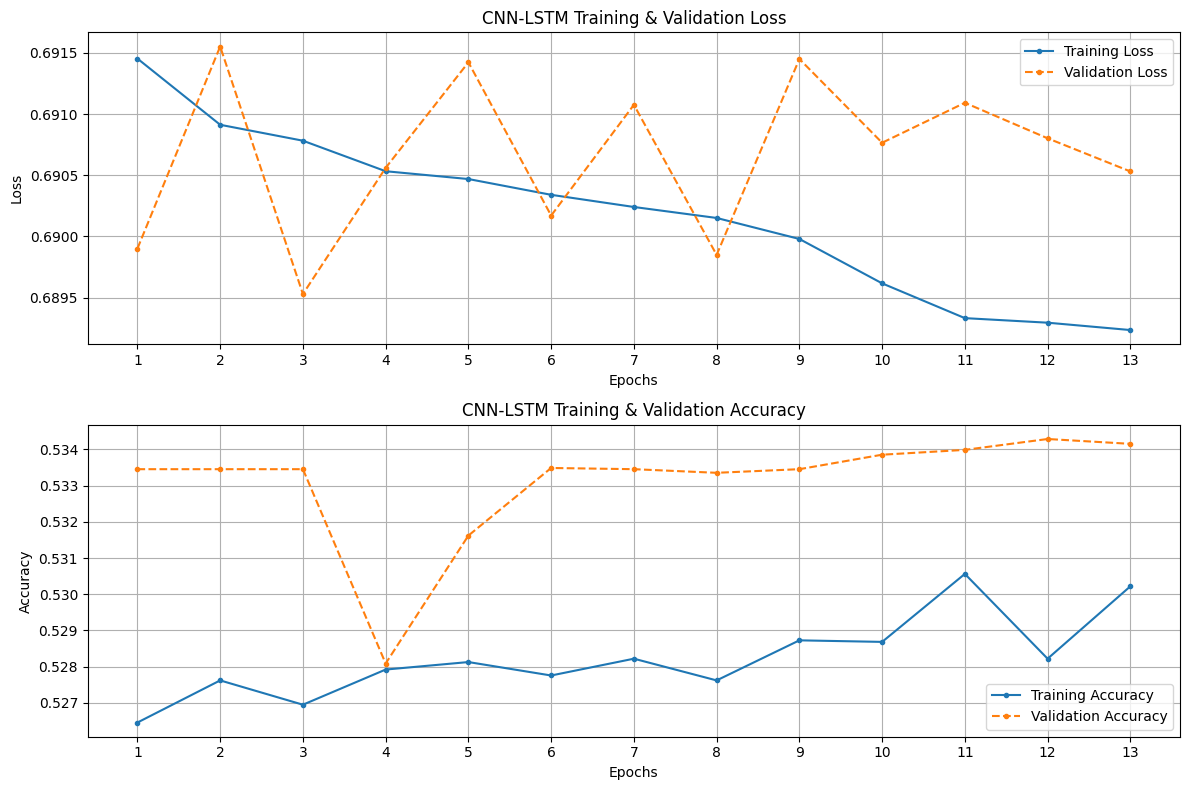

In [ ]:
# =========================================
# Cell 26: Plot Training & Validation Curves
# =========================================
epochs_trained = len(cnn_lstm_train_losses) # Get actual epochs trained
if epochs_trained > 0: # Check if training actually ran
    plt.figure(figsize=(12, 8)) #

    # Plot Loss
    plt.subplot(2, 1, 1) #
    plt.plot(range(1, epochs_trained + 1), cnn_lstm_train_losses, label='Training Loss', marker='.') #
    # Check if validation loss list is not empty and contains valid numbers
    if cnn_lstm_val_losses and any(v is not None and not np.isnan(v) for v in cnn_lstm_val_losses): #
        plt.plot(range(1, epochs_trained + 1), [v for v in cnn_lstm_val_losses], label='Validation Loss', linestyle='--', marker='.') # Filter out None/NaN #
    plt.title('CNN-LSTM Training & Validation Loss') #
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True) #
    plt.xticks(range(1, epochs_trained + 1, max(1, epochs_trained // 10))) # Adjust x-ticks for readability

    # Plot Accuracy
    plt.subplot(2, 1, 2) #
    plt.plot(range(1, epochs_trained + 1), cnn_lstm_train_accuracies, label='Training Accuracy', marker='.') #
    if cnn_lstm_val_accuracies and any(v is not None and not np.isnan(v) for v in cnn_lstm_val_accuracies): #
        plt.plot(range(1, epochs_trained + 1), [v for v in cnn_lstm_val_accuracies], label='Validation Accuracy', linestyle='--', marker='.') # Filter out None/NaN #
    plt.title('CNN-LSTM Training & Validation Accuracy') #
    plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True) #
    plt.xticks(range(1, epochs_trained + 1, max(1, epochs_trained // 10))) # Adjust x-ticks

    plt.tight_layout() #
    plot_filename = 'cnn_lstm_training_curves.png' #
    plt.savefig(plot_filename) #
    print(f"\nTraining/Validation curves plot saved to {plot_filename}") #
    plt.show() #
else:
    print("Skipping plotting as no training epochs were completed.") #

In [ ]:
# =========================================
# Cell 27: Evaluate the BEST CNN-LSTM Model on Test Set
# =========================================
if cnn_lstm_best_model_state: #
    print("\nLoading best CNN-LSTM model state for final test evaluation...") #
    cnn_lstm_model.load_state_dict(cnn_lstm_best_model_state) #

    # Evaluate the loaded model on the test set
    cnn_lstm_y_pred_test, cnn_lstm_y_true_test, cnn_lstm_test_accuracy, cnn_lstm_test_loss = evaluate_model(
        cnn_lstm_model, test_loader, criterion, device #
    )

    if cnn_lstm_test_accuracy is not None: # Check if evaluation returned a valid accuracy #
        cnn_lstm_test_accuracy_percentage = cnn_lstm_test_accuracy * 100 #
        print(f"\nFinal Test Accuracy (using best CNN-LSTM model): {cnn_lstm_test_accuracy_percentage:.2f}%") #
        print(f"Final Test Loss (using best CNN-LSTM model): {cnn_lstm_test_loss:.4f}") #
    else:
        cnn_lstm_test_accuracy_percentage = 0.0 #
        print("\nCould not calculate final test accuracy (evaluation might have failed or test set empty).") #
else:
    print("\nError: No best CNN-LSTM model state available to evaluate (training might have failed).") #
    cnn_lstm_test_accuracy_percentage = 0.0 #
    cnn_lstm_test_loss = None # Indicate loss is unavailable

# Store final test accuracy for potential later comparison
final_test_accuracy_cnn_lstm = cnn_lstm_test_accuracy_percentage


Loading best CNN-LSTM model state for final test evaluation...

--- Starting Model Evaluation ---
Evaluation Loss: 0.6910, Evaluation Accuracy: 0.5248

Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      1.00      0.69     15735
         1.0       0.00      0.00      0.00     14245

    accuracy                           0.52     29980
   macro avg       0.26      0.50      0.34     29980
weighted avg       0.28      0.52      0.36     29980


Confusion Matrix:
[[15735     0]
 [14245     0]]
--- Model Evaluation Finished ---

Final Test Accuracy (using best CNN-LSTM model): 52.48%
Final Test Loss (using best CNN-LSTM model): 0.6910


In [ ]:
# =========================================
# Cell 28: Save the BEST CNN-LSTM Model
# =========================================
cnn_lstm_model_save_path = 'bitcoin_cnn_lstm_best_model.pth' #
print(f"\nSaving BEST CNN-LSTM model state dictionary to {cnn_lstm_model_save_path}...") #
if cnn_lstm_best_model_state: #
    try:
        torch.save(cnn_lstm_best_model_state, cnn_lstm_model_save_path) #
        print("Best CNN-LSTM model state saved successfully.") #
    except Exception as e:
        print(f"Error saving model state: {e}")
else:
    print("Warning: No best CNN-LSTM model state found to save.") #



Saving BEST CNN-LSTM model state dictionary to bitcoin_cnn_lstm_best_model.pth...
Best CNN-LSTM model state saved successfully.


In [ ]:
# =========================================
# Cell 29: Probability & Position Generation Functions
# =========================================
# --- Function to get probabilities from model --- (from improve.txt Cell 23)
def get_probabilities(model, data_loader, device): #
    """Generates prediction probabilities for the given data_loader."""
    model.eval() # Set model to evaluation mode
    probabilities = [] #
    print("\nGenerating prediction probabilities...") #
    if data_loader is None:
        print("Skipping probability generation: data_loader is None.")
        return np.array([])

    with torch.no_grad(): # Disable gradient calculations #
        for inputs, _ in data_loader: # Iterate through batches
            inputs = inputs.to(device) # Move data to device #
            outputs = model(inputs).squeeze() # Get model outputs (squeeze removes extra dim) #
            # Handle case where dataloader might return a single batch result not as list
            if outputs.dim() == 0: # If scalar tensor #
                 probabilities.append(outputs.cpu().item()) # Append single value #
            else:
                 probabilities.extend(outputs.cpu().numpy()) # Append batch of values #
    print("Probability generation complete.") #
    return np.array(probabilities) # Return as numpy array #

# --- Function for Fixed Threshold Positions --- (from improve.txt Cell 24)
def get_fixed_threshold_positions(probabilities, threshold_buy=0.6, threshold_sell=0.4): # Renamed for clarity
    """Generates trading positions based on fixed thresholds."""
    if not (0 < threshold_sell < threshold_buy < 1): #
        print(f"Warning: Invalid fixed thresholds (buy={threshold_buy}, sell={threshold_sell}). Using defaults.")
        threshold_buy=0.6; threshold_sell=0.4
    positions = np.zeros(len(probabilities)) # Initialize positions as 0 (Neutral/Hold) #
    positions[probabilities > threshold_buy] = 1 # Set Buy signal #
    positions[probabilities < threshold_sell] = -1 # Set Sell signal #
    print(f"Fixed threshold positions generated: Buy > {threshold_buy}, Sell < {threshold_sell}") #
    return positions #

# --- Function for Dynamic Threshold Positions --- (from improve.txt Cell 24.5)
def get_dynamic_threshold_positions(probabilities, volatility_values, base_threshold_buy=0.55, base_threshold_sell=0.45, volatility_factor=0.1, min_threshold_diff=0.05): # Renamed & added min_diff
    """Generates trading positions based on dynamic thresholds adjusted by volatility."""
    if len(probabilities) != len(volatility_values): #
        # Try to align if off by a small amount (e.g., sequence creation edge case)
        min_len = min(len(probabilities), len(volatility_values)) #
        print(f"Warning: Length mismatch in dynamic thresholds. Prob: {len(probabilities)}, Vol: {len(volatility_values)}. Aligning to {min_len} values.") #
        probabilities = probabilities[:min_len] #
        volatility_values = volatility_values[:min_len] #

    volatility_values = np.maximum(volatility_values, 0) # Ensure non-negative volatility #
    # Consider normalizing volatility if its scale varies greatly, e.g., using rolling percentile
    # vol_norm = (volatility_values - np.mean(volatility_values)) / (np.std(volatility_values) + 1e-9) # Z-score example

    thresholds_buy = base_threshold_buy + volatility_values * volatility_factor #
    thresholds_sell = base_threshold_sell - volatility_values * volatility_factor #

    # Ensure buy > sell and add minimum separation
    thresholds_buy = np.maximum(thresholds_buy, thresholds_sell + min_threshold_diff)

    # Clip thresholds to valid probability ranges (e.g., 0.05 to 0.95)
    thresholds_buy = np.clip(thresholds_buy, 0.5 + min_threshold_diff / 2, 0.95) # Ensure buy > 0.5 #
    thresholds_sell = np.clip(thresholds_sell, 0.05, 0.5 - min_threshold_diff / 2) # Ensure sell < 0.5 #

    positions = np.zeros(len(probabilities)) # Initialize positions #
    positions[probabilities > thresholds_buy] = 1  # Buy signal
    positions[probabilities < thresholds_sell] = -1 # Sell signal

    # for i in range(len(probabilities)): # Original loop for debugging if needed
    #     if probabilities[i] > thresholds_buy[i]: positions[i] = 1
    #     elif probabilities[i] < thresholds_sell[i]: positions[i] = -1

    print(f"Dynamic threshold positions generated using volatility factor {volatility_factor}.") #
    # print(f"Example thresholds (first 5): Buy={thresholds_buy[:5]}, Sell={thresholds_sell[:5]}") # Optional: Print example thresholds
    return positions #

print("Probability and position generation functions defined.")


Probability and position generation functions defined.


In [ ]:
# =========================================
# Cell 30: Stop Loss Function Definition
# =========================================
# Use the function from improve.txt Cell 26.5

def implement_stop_loss(positions, prices, stop_percent=0.02): #
    """Applies a simple stop-loss logic to trading positions."""
    print(f"Applying stop loss simulation with stop_percent={stop_percent:.2%}...") #
    if len(positions) != len(prices): #
         min_len = min(len(positions), len(prices)) #
         print(f"Warning: Length mismatch in stop loss. Pos: {len(positions)}, Prices: {len(prices)}. Aligning to {min_len} values.") #
         positions = positions[:min_len] #
         prices = prices[:min_len] #

    positions_sl = np.copy(positions) # Work on a copy to preserve original signals #
    active_pos_type = 0      # Current state: 0=flat, 1=long, -1=short
    entry_price = 0.0        # Price at which the current position was entered
    stop_loss_price = 0.0    # Price level at which to exit the current position

    for i in range(len(prices)): # Iterate through each time step
        current_price = prices[i] #
        original_signal = positions[i] # Signal for *this* time step from the model

        # --- 1. Check if stop loss was hit based on the *previous* state ---
        stop_hit = False #
        if active_pos_type == 1 and current_price < stop_loss_price: # Check long stop loss #
            stop_hit = True #
            # print(f"Stop Loss HIT LONG at index {i}, Price: {current_price:.2f}, SL: {stop_loss_price:.2f}") # Debug print
        elif active_pos_type == -1 and current_price > stop_loss_price: # Check short stop loss #
            stop_hit = True #
            # print(f"Stop Loss HIT SHORT at index {i}, Price: {current_price:.2f}, SL: {stop_loss_price:.2f}") # Debug print

        if stop_hit:
            active_pos_type = 0 # Exit position #
            positions_sl[i] = 0 # Force exit signal *at this point* due to SL #
            entry_price = 0.0 # Reset entry price #
            stop_loss_price = 0.0 # Reset SL price #
            # NOTE: This simple version allows immediate re-entry if the original signal persists.
            # More complex logic could enforce a waiting period after a stop-out.

        # --- 2. Determine action based on the original signal, considering current state ---
        if active_pos_type == 0: # If currently flat
            if original_signal != 0: # Signal to enter a new position
                active_pos_type = original_signal # Set new position type (1 or -1) #
                entry_price = current_price # Record entry price #
                # Calculate stop loss price based on entry
                stop_loss_price = entry_price * (1 - stop_percent * active_pos_type) # Correct calculation for long/short #
                positions_sl[i] = active_pos_type # Reflect the entry in the SL-adjusted signals #
                # print(f"Entry {'Long' if active_pos_type==1 else 'Short'} at {i}, Price: {entry_price:.2f}, SL: {stop_loss_price:.2f}") # Debug print
            # else: remain flat (original_signal is 0), positions_sl[i] is already 0 unless SL hit

        else: # If already in a position (long or short)
            if original_signal == 0 or original_signal == -active_pos_type: # Signal to exit or reverse
                 # print(f"Exit/Reverse {'Long' if active_pos_type==1 else 'Short'} at {i}, Signal: {original_signal}, Price: {current_price:.2f}") # Debug print
                exit_pos_type = active_pos_type # Store type before changing
                active_pos_type = original_signal # Set new state (0 for exit, -1 or 1 for reversal) #
                positions_sl[i] = active_pos_type # Reflect exit/reversal in SL signals #

                if active_pos_type != 0: # If it was a reversal (not just exit to flat)
                    entry_price = current_price # Set new entry price for the reversed position #
                    stop_loss_price = entry_price * (1 - stop_percent * active_pos_type) # Calculate new SL #
                    # print(f"Reversal Entry {'Long' if active_pos_type==1 else 'Short'} at {i}, Price: {entry_price:.2f}, SL: {stop_loss_price:.2f}") # Debug print
                else: # Exited to flat
                    entry_price = 0.0; stop_loss_price = 0.0 # Reset entry/SL prices #

            else: # Signal confirms holding the existing position (original_signal == active_pos_type)
                 positions_sl[i] = active_pos_type # Maintain the position signal #
                 # Optional: Implement trailing stop loss here if desired
                 # if active_pos_type == 1: stop_loss_price = max(stop_loss_price, current_price * (1-stop_percent))
                 # elif active_pos_type == -1: stop_loss_price = min(stop_loss_price, current_price * (1+stop_percent))

    print("Stop loss simulation applied.") #
    return positions_sl # Return the signals adjusted for stop losses #

print("Stop loss function 'implement_stop_loss' defined.") #

Stop loss function 'implement_stop_loss' defined.


In [ ]:
# =========================================
# Cell 31: Generate Predictions & Signals for Test Set using CNN-LSTM
# =========================================
# Ensure the best model state is loaded
if cnn_lstm_best_model_state: #
    cnn_lstm_model.load_state_dict(cnn_lstm_best_model_state) #
    print("Best CNN-LSTM model state loaded for prediction.")
elif 'cnn_lstm_model' in locals():
    print("Warning: Best CNN-LSTM model state not found. Using the current model state for prediction.") #
else:
    raise NameError("CNN-LSTM model not available for prediction.")

# Generate probabilities on the test set
cnn_lstm_y_pred_proba_test = get_probabilities(cnn_lstm_model, test_loader, device) #

# --- Choose Signal Generation Method ---
use_dynamic_thresholds = True # Set to True to use dynamic, False for fixed
volatility_col_for_thresholds = 'ATR' # Column to use for dynamic thresholds (e.g., 'ATR', 'Volatility_14d')
base_buy = 0.55
base_sell = 0.45
vol_factor = 0.1

# Align volatility metric with test predictions
# Need the original dataframe 'df' and split indices from Cell 15
# test_start_index_in_df = final_train_size + val_size + time_steps # Start index in ORIGINAL df for test targets
# test_end_index_in_df = test_start_index_in_df + len(y_test_seq) # End index

# Recalculate indices based on lengths from Cell 15 and time_steps from Cell 17
# Note: The split was on X_scaled, length len(X_scaled). Sequences start 'time_steps' later.
# The targets y_test_seq correspond to predictions cnn_lstm_y_pred_proba_test
# We need the volatility from the time points corresponding to y_test_seq

test_target_start_index_in_df = final_train_size + val_size + time_steps # Index in original df where test targets BEGIN
test_target_end_index_in_df = final_train_size + val_size + test_size # Index in original df where test targets END (exclusive)

if len(cnn_lstm_y_pred_proba_test) != (test_target_end_index_in_df - test_target_start_index_in_df):
    print(f"Warning: Length mismatch between predictions ({len(cnn_lstm_y_pred_proba_test)}) and expected target slice size ({test_target_end_index_in_df - test_target_start_index_in_df}). Check split/sequence logic.")
    # Adjust end index if lengths misalign, but this might indicate an earlier issue
    test_target_end_index_in_df = test_target_start_index_in_df + len(cnn_lstm_y_pred_proba_test)


if use_dynamic_thresholds and volatility_col_for_thresholds in df.columns: #
    # Extract volatility values corresponding to the test set predictions
    test_volatility = df[volatility_col_for_thresholds].iloc[test_target_start_index_in_df : test_target_end_index_in_df].values #
    test_volatility = np.nan_to_num(test_volatility, nan=np.nanmean(test_volatility)) # Handle potential NaNs #

    print(f"\nUsing Dynamic Thresholds based on '{volatility_col_for_thresholds}'. Shape: {test_volatility.shape}") #
    if len(cnn_lstm_y_pred_proba_test) == len(test_volatility): # Check alignment again
         cnn_lstm_test_positions = get_dynamic_threshold_positions( #
             cnn_lstm_y_pred_proba_test, test_volatility, #
             base_threshold_buy=base_buy, base_threshold_sell=base_sell, volatility_factor=vol_factor # Adjust params
         ) #
    else:
         print(f"Error: Length mismatch after extracting volatility Prob({len(cnn_lstm_y_pred_proba_test)}) vs Vol({len(test_volatility)}). Falling back to fixed thresholds.") #
         cnn_lstm_test_positions = get_fixed_threshold_positions(cnn_lstm_y_pred_proba_test, threshold_buy=base_buy, threshold_sell=base_sell) # Fallback #
else:
    if use_dynamic_thresholds: print(f"\nWarning: Volatility column '{volatility_col_for_thresholds}' not found. Using fixed thresholds.") #
    else: print("\nUsing Fixed Thresholds.")
    cnn_lstm_test_positions = get_fixed_threshold_positions(cnn_lstm_y_pred_proba_test, threshold_buy=base_buy, threshold_sell=base_sell) # Fallback or intended fixed #

print(f"Generated {len(cnn_lstm_test_positions)} initial trading positions for CNN-LSTM.") #

Best CNN-LSTM model state loaded for prediction.

Generating prediction probabilities...
Probability generation complete.

Using Dynamic Thresholds based on 'ATR'. Shape: (29980,)
Dynamic threshold positions generated using volatility factor 0.1.
Generated 29980 initial trading positions for CNN-LSTM.


In [ ]:
# =========================================
# Cell 32: Prepare Data for Backtest
# =========================================
# Get dates and prices corresponding to the prediction targets/positions
# Use the same indices calculated in Cell 31
test_dates = df.index[test_target_start_index_in_df : test_target_end_index_in_df] #
test_prices = df[price_col].iloc[test_target_start_index_in_df : test_target_end_index_in_df].values # Use the primary price column #

# Ensure lengths match before stop loss / backtest
min_len_backtest = min(len(test_dates), len(test_prices), len(cnn_lstm_test_positions)) #
if len(test_dates) != min_len_backtest or len(test_prices) != min_len_backtest or len(cnn_lstm_test_positions) != min_len_backtest: #
     print(f"Warning: Aligning dates/prices/positions for backtest to minimum length: {min_len_backtest}") #
     test_dates = test_dates[:min_len_backtest] #
     test_prices = test_prices[:min_len_backtest] #
     cnn_lstm_test_positions = cnn_lstm_test_positions[:min_len_backtest] #

print(f"\nAligned dates, prices, and positions for backtesting. Length: {len(cnn_lstm_test_positions)}") #
if len(cnn_lstm_test_positions) == 0:
    raise ValueError("No positions available for backtesting. Check data alignment and prediction steps.")



Aligned dates, prices, and positions for backtesting. Length: 29980


In [ ]:
# =========================================
# Cell 33: Apply Stop Loss Simulation to CNN-LSTM Positions
# =========================================
stop_loss_percentage = 0.02 # Example: 2% stop loss

cnn_lstm_test_positions_with_sl = implement_stop_loss( #
    cnn_lstm_test_positions, test_prices, stop_percent=stop_loss_percentage #
)

print(f"Generated {len(cnn_lstm_test_positions_with_sl)} positions after stop loss simulation.") #

Applying stop loss simulation with stop_percent=2.00%...
Stop loss simulation applied.
Generated 29980 positions after stop loss simulation.


In [ ]:
# =========================================
# Cell 34: Run Backtest Simulation for CNN-LSTM
# =========================================
print("\nCalculating CNN-LSTM strategy returns using positions WITH stop loss...") #
# Use the positions modified by the stop loss function
cnn_lstm_strategy_returns = np.zeros(len(cnn_lstm_test_positions_with_sl)) # Initialize returns array #
cnn_lstm_trade_count = 0 # Initialize trade counter #

for i in range(1, len(cnn_lstm_test_positions_with_sl)): # Start from second time step
    position_held = cnn_lstm_test_positions_with_sl[i-1] # Position decided based on signal BEFORE period i starts #
    price_prev = test_prices[i-1] # Price at the start of period i
    price_curr = test_prices[i] # Price at the end of period i

    if price_prev == 0: continue # Skip if previous price is zero to avoid division errors #

    # Detect trades (change in position) for counting
    if cnn_lstm_test_positions_with_sl[i] != cnn_lstm_test_positions_with_sl[i-1]: #
        cnn_lstm_trade_count += 1 #

    # Calculate return based on the position held *during* period i
    if position_held == 1: # If held long position
        cnn_lstm_strategy_returns[i] = (price_curr / price_prev) - 1 # Long return #
    elif position_held == -1: # If held short position
        cnn_lstm_strategy_returns[i] = (price_prev / price_curr) - 1 # Short return (inverted price ratio) #
    # else: position_held == 0, return is 0 (already initialized)

# Calculate cumulative returns
# Add 1 for cumulative product, subtract 1 at the end
cnn_lstm_strategy_cumulative_returns = (1 + cnn_lstm_strategy_returns).cumprod() - 1 #

# Calculate Buy-and-Hold returns for comparison using test_prices
if len(test_prices) > 0 and test_prices[0] != 0:
    buy_hold_returns = (test_prices / test_prices[0]) - 1 #
else:
    buy_hold_returns = np.zeros(len(test_prices)) # Avoid division by zero if first price is 0

print("CNN-LSTM return calculations complete.") #
print(f"Approximate CNN-LSTM Trade Count (based on SL-modified signals): {cnn_lstm_trade_count}") #


Calculating CNN-LSTM strategy returns using positions WITH stop loss...
CNN-LSTM return calculations complete.
Approximate CNN-LSTM Trade Count (based on SL-modified signals): 0



CNN-LSTM strategy performance plot saved to cnn_lstm_strategy_performance.png


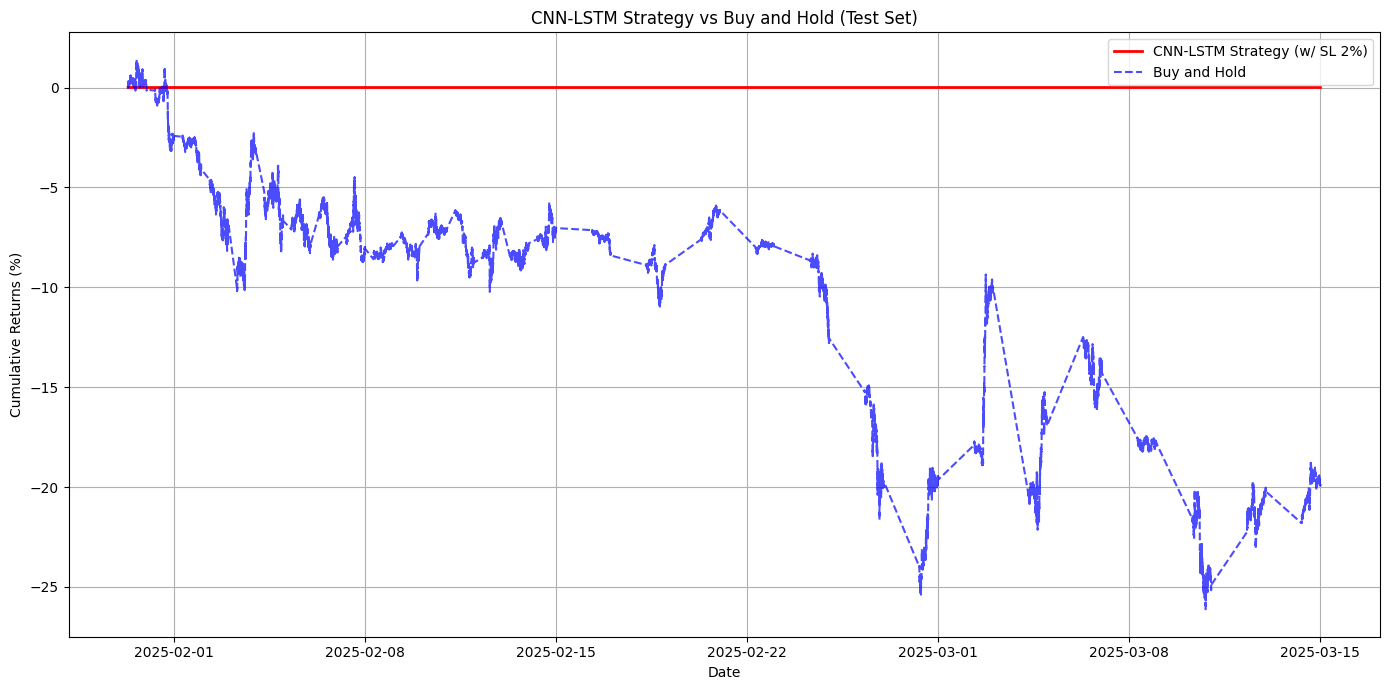

In [ ]:
# =========================================
# Cell 35: Plot CNN-LSTM Backtest Results
# =========================================
plt.figure(figsize=(14, 7)) #

# Plot CNN-LSTM Strategy Returns
plt.plot(test_dates, cnn_lstm_strategy_cumulative_returns * 100,
         label=f'CNN-LSTM Strategy (w/ SL {stop_loss_percentage*100:.0f}%)', color='red', linewidth=2) #

# Plot Buy and Hold Returns
plt.plot(test_dates, buy_hold_returns * 100, label='Buy and Hold', alpha=0.7, color='blue', linestyle='--') #

# --- Optional: Add Original LSTM results for comparison ---
# Check if original LSTM results exist from a previous run/notebook part
# Assuming 'strategy_cumulative_returns' holds original LSTM results
# if 'strategy_cumulative_returns' in locals() and len(strategy_cumulative_returns) == len(test_dates):
#     plt.plot(test_dates, strategy_cumulative_returns * 100,
#              label=f'Original LSTM Strategy (w/ SL {stop_loss_percentage*100:.0f}%)',
#              color='green', linestyle=':')

plt.title('CNN-LSTM Strategy vs Buy and Hold (Test Set)') #
plt.xlabel('Date') #
plt.ylabel('Cumulative Returns (%)') #
plt.legend() #
plt.grid(True) #
plt.tight_layout() #

# Save the plot
cnn_lstm_perf_plot_filename = 'cnn_lstm_strategy_performance.png' #
plt.savefig(cnn_lstm_perf_plot_filename) #
print(f"\nCNN-LSTM strategy performance plot saved to {cnn_lstm_perf_plot_filename}") #
plt.show() #

In [ ]:
# =========================================
# Cell 36: Display CNN-LSTM Backtest Statistics
# =========================================
cnn_lstm_final_return = cnn_lstm_strategy_cumulative_returns[-1] * 100 if len(cnn_lstm_strategy_cumulative_returns) > 0 else 0 #
buyhold_final_return = buy_hold_returns[-1] * 100 if len(buy_hold_returns) > 0 else 0 #

# Optional: Get original LSTM final return if available
# original_lstm_final_return = strategy_cumulative_returns[-1] * 100 if 'strategy_cumulative_returns' in locals() and len(strategy_cumulative_returns) > 0 else 0

print("\n--- CNN-LSTM Backtest Summary ---") #
if len(test_dates) > 0: #
    print(f"Test Period Start Date: {test_dates[0].strftime('%Y-%m-%d')}") # Format date
    print(f"Test Period End Date:   {test_dates[-1].strftime('%Y-%m-%d')}") # Format date
else:
    print("Test Period: Empty") #

print("\nFinal Cumulative Returns:")
print(f"CNN-LSTM Strategy: {cnn_lstm_final_return:.2f}% (Using SL-modified signals)") #
# print(f"Original LSTM:     {original_lstm_final_return:.2f}% (If compared)") # Optional comparison
print(f"Buy and Hold:      {buyhold_final_return:.2f}%") #

# Signal distribution comparison (Using SL-modified signals)
cnn_lstm_num_buy = np.sum(cnn_lstm_test_positions_with_sl == 1) #
cnn_lstm_num_sell = np.sum(cnn_lstm_test_positions_with_sl == -1) #
cnn_lstm_num_neutral = np.sum(cnn_lstm_test_positions_with_sl == 0) #
cnn_lstm_total_signals = len(cnn_lstm_test_positions_with_sl) #

print("\nCNN-LSTM Signal Distribution (After Stop Loss):") #
if cnn_lstm_total_signals > 0: #
    print(f" - Total Time Long:    {cnn_lstm_num_buy} ({cnn_lstm_num_buy/cnn_lstm_total_signals*100:.1f}%)") #
    print(f" - Total Time Short:   {cnn_lstm_num_sell} ({cnn_lstm_num_sell/cnn_lstm_total_signals*100:.1f}%)") #
    print(f" - Total Time Neutral: {cnn_lstm_num_neutral} ({cnn_lstm_num_neutral/cnn_lstm_total_signals*100:.1f}%)") #
else:
    print("No CNN-LSTM signals generated for distribution analysis.") #

# Compare test accuracy (Calculated in Cell 27)
print("\nModel Accuracy on Test Set:")
print(f"CNN-LSTM Test Accuracy: {final_test_accuracy_cnn_lstm:.2f}%") # Use stored variable #
# print(f"Original LSTM Test Accuracy: {test_accuracy_percentage:.2f}%") # Optional: From original model's run

# Add Trade Count
print(f"\nApproximate Trade Count: {cnn_lstm_trade_count}") #

print("--------------------------------") #



--- CNN-LSTM Backtest Summary ---
Test Period Start Date: 2025-01-30
Test Period End Date:   2025-03-15

Final Cumulative Returns:
CNN-LSTM Strategy: 0.00% (Using SL-modified signals)
Buy and Hold:      -19.87%

CNN-LSTM Signal Distribution (After Stop Loss):
 - Total Time Long:    0 (0.0%)
 - Total Time Short:   0 (0.0%)
 - Total Time Neutral: 29980 (100.0%)

Model Accuracy on Test Set:
CNN-LSTM Test Accuracy: 52.48%

Approximate Trade Count: 0
--------------------------------


In [ ]:
# =========================================
# Cell 37: Prediction Function Definition for New Data (CNN-LSTM)
# =========================================
# Based on improve.txt Cell 31

def predict_trade_signal_cnn_lstm(new_data_df, model, scaler, feature_columns, time_steps, device,
                                  threshold_buy=0.55, threshold_sell=0.45, # Default thresholds
                                  use_dynamic=True, vol_col='ATR', vol_factor=0.1, min_threshold_diff=0.05): # Allow configuring prediction thresholds
    """Predicts the next trading signal using the trained CNN-LSTM model on new data."""
    print("\n--- Predicting on New Data with CNN-LSTM Model ---") #

    # 1. Input Validation
    if len(new_data_df) < time_steps: #
        print(f"Error: Need at least {time_steps} rows for sequence, got {len(new_data_df)}.") #
        return None, None # Return None for probability and signal

    missing_cols = [col for col in feature_columns if col not in new_data_df.columns] #
    if missing_cols: #
        print(f"Error: New data is missing required feature columns: {missing_cols}") #
        return None, None #

    # 2. Prepare Input Data
    # Select the last 'time_steps' rows and the required features
    X_new = new_data_df[feature_columns].iloc[-time_steps:].values #
    if np.isnan(X_new).any(): # Check for NaNs in the final input sequence #
        print(f"Error: NaNs detected in the last {time_steps} rows of the selected features. Cannot predict.") #
        return None, None #

    # 3. Scale Data
    # Use the *same* scaler that was fitted on the training data
    X_new_scaled = scaler.transform(X_new) # Use transform, NOT fit_transform #

    # 4. Create Sequence and Tensor
    # Reshape for model input: (1, time_steps, n_features)
    X_new_seq = np.array([X_new_scaled]) # Add batch dimension #
    X_new_tensor = torch.FloatTensor(X_new_seq).to(device) # Convert to tensor and move to device #

    # 5. Make Prediction
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradients for prediction
        probability = model(X_new_tensor).squeeze().cpu().item() # Get probability output #

    # 6. Determine Signal (Dynamic or Fixed)
    signal = 0 # Default to neutral
    if use_dynamic: #
        if vol_col in new_data_df.columns: #
            # Get the *last* volatility value from the input data frame
            last_volatility = new_data_df[vol_col].iloc[-1] #
            last_volatility = np.nan_to_num(last_volatility, nan=0.0) # Handle potential NaN in volatility #
            last_volatility = max(0, last_volatility) # Ensure non-negative

            # Calculate dynamic thresholds
            dynamic_buy = threshold_buy + last_volatility * vol_factor #
            dynamic_sell = threshold_sell - last_volatility * vol_factor #

            # Ensure buy > sell and clip
            dynamic_buy = max(dynamic_buy, dynamic_sell + min_threshold_diff)
            dynamic_buy = np.clip(dynamic_buy, 0.5 + min_threshold_diff / 2, 0.95) #
            dynamic_sell = np.clip(dynamic_sell, 0.05, 0.5 - min_threshold_diff / 2) #

            print(f"Using dynamic thresholds based on last '{vol_col}' ({last_volatility:.4f}): Buy > {dynamic_buy:.3f}, Sell < {dynamic_sell:.3f}") #
            if probability > dynamic_buy: signal = 1 #
            elif probability < dynamic_sell: signal = -1 #
            else: signal = 0 #

        else: # Fallback to fixed if volatility column not found
            print(f"Warning: Volatility column '{vol_col}' not found for dynamic threshold. Using fixed.") #
            if probability > threshold_buy: signal = 1 #
            elif probability < threshold_sell: signal = -1 #
            else: signal = 0 #
    else: # Use fixed thresholds
        print(f"Using fixed thresholds: Buy > {threshold_buy}, Sell < {threshold_sell}") #
        if probability > threshold_buy: signal = 1 #
        elif probability < threshold_sell: signal = -1 #
        else: signal = 0 #

    print(f"CNN-LSTM Prediction for next timestep: Probability={probability:.4f}, Signal={signal}") #
    print("-----------------------------") #
    return probability, signal # Return both probability and the final signal #

print("Prediction function 'predict_trade_signal_cnn_lstm' defined.") #


Prediction function 'predict_trade_signal_cnn_lstm' defined.


In [ ]:
# =========================================
# Cell 38: Example Usage for New Data Prediction using CNN-LSTM
# =========================================
print("\n--- Example: Using the CNN-LSTM model for a new prediction ---") #

# This cell demonstrates how to use the prediction function.
# In a real scenario, you would fetch *new* data and preprocess it *exactly*
# as the training data was processed (Cells 5-12).

# For demonstration, we use the last `time_steps` rows from the fully processed `df`.
if 'df' in locals() and len(df) >= time_steps and 'cnn_lstm_model' in locals() and 'scaler' in locals() and 'feature_columns' in locals(): # Check required vars exist #
    demo_new_data = df.iloc[-time_steps:].copy() # Use last processed rows for demo #
    print(f"Using last {time_steps} rows of processed data (shape: {demo_new_data.shape}) for demo prediction.") #

    # Call the prediction function
    cnn_lstm_probability, cnn_lstm_signal = predict_trade_signal_cnn_lstm(
        new_data_df=demo_new_data,        # The dataframe slice (must be fully preprocessed)
        model=cnn_lstm_model,             # The trained CNN-LSTM model
        scaler=scaler,                    # The scaler fitted on training data
        feature_columns=feature_columns,  # List of features the model expects
        time_steps=time_steps,            # Lookback window size
        device=device,                    # CPU or GPU device
        threshold_buy=0.55,               # Base threshold for dynamic or fixed buy
        threshold_sell=0.45,              # Base threshold for dynamic or fixed sell
        use_dynamic=True,                 # Use dynamic thresholds?
        vol_col='ATR',                    # Volatility column for dynamic thresholds
        vol_factor=0.1                    # Factor to adjust thresholds by volatility
    ) #

    # Interpret the predicted signal
    if cnn_lstm_signal is not None: # Check if prediction was successful
        print("\nCNN-LSTM Predicted Trading Action for the NEXT time step:") #
        if cnn_lstm_signal == 1: #
            print("  >> BUY") #
        elif cnn_lstm_signal == -1: #
            print("  >> SELL") #
        else: # cnn_lstm_signal == 0
            print("  >> HOLD / NEUTRAL") #
    else:
        print("\nCNN-LSTM prediction failed (check errors above).") #
else:
    print("\nCannot run prediction example: Check if 'df', 'cnn_lstm_model', 'scaler', 'feature_columns', 'time_steps' are available and 'df' has enough rows.") #



--- Example: Using the CNN-LSTM model for a new prediction ---
Using last 20 rows of processed data (shape: (20, 54)) for demo prediction.

--- Predicting on New Data with CNN-LSTM Model ---
Using dynamic thresholds based on last 'ATR' (27.3571): Buy > 0.950, Sell < 0.050
CNN-LSTM Prediction for next timestep: Probability=0.4631, Signal=0
-----------------------------

CNN-LSTM Predicted Trading Action for the NEXT time step:
  >> HOLD / NEUTRAL


In [ ]:
# =========================================
# Cell 39: Simple Trading Strategy Guide Summary
# =========================================
print("\n--- Simple Bitcoin Trading Strategy Guide (CNN-LSTM Model) ---") #
print(f"1. Model Type: Convolutional Neural Network (CNN) + Long Short-Term Memory (LSTM) with Attention.") #
print(f"2. Input Features ({len(feature_columns)}): Includes OHLCV, technical indicators (MAs, MACD, RSI, BB, Stoch, ATR), volume metrics, volatility, trend indicators, and potentially flow/on-chain proxies.") #
print(f"3. Lookback Window: Uses the previous {time_steps} time steps to predict the next step.") #
print(f"4. Training: Includes Validation Set, Early Stopping (patience={early_stopping_patience}), LR Scheduling, Gradient Clipping. Optional SMOTE balancing.") #
print(f"5. Signal Generation: Uses {'Dynamic thresholds based on ' + volatility_col_for_thresholds if use_dynamic_thresholds else 'Fixed thresholds'} (Base Buy > {base_buy}, Base Sell < {base_sell}).") #
print(f"6. Backtest Simulation: Includes a {stop_loss_percentage*100:.0f}% stop loss.") #
print(f"7. Best Model's Test Accuracy: {final_test_accuracy_cnn_lstm:.2f}%") # Use stored variable #
print("\nDisclaimer: This is an educational model. Past performance is not indicative of future results. Trading involves significant risk.") #
print("-----------------------------------------") #
print("\n====================================================")
print("CNN-LSTM Model Pipeline Execution Complete!")
print("====================================================")


--- Simple Bitcoin Trading Strategy Guide (CNN-LSTM Model) ---
1. Model Type: Convolutional Neural Network (CNN) + Long Short-Term Memory (LSTM) with Attention.
2. Input Features (40): Includes OHLCV, technical indicators (MAs, MACD, RSI, BB, Stoch, ATR), volume metrics, volatility, trend indicators, and potentially flow/on-chain proxies.
3. Lookback Window: Uses the previous 20 time steps to predict the next step.
4. Training: Includes Validation Set, Early Stopping (patience=10), LR Scheduling, Gradient Clipping. Optional SMOTE balancing.
5. Signal Generation: Uses Dynamic thresholds based on ATR (Base Buy > 0.55, Base Sell < 0.45).
6. Backtest Simulation: Includes a 2% stop loss.
7. Best Model's Test Accuracy: 52.48%

Disclaimer: This is an educational model. Past performance is not indicative of future results. Trading involves significant risk.
-----------------------------------------

CNN-LSTM Model Pipeline Execution Complete!
